In [1]:
#conda install -c conda-forge librosa

# Package Import

In [2]:
import pandas as pd
import librosa
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
_3sec = pd.read_csv('Data/features_3_sec.csv')
_30sec = pd.read_csv('Data/features_30_sec.csv')

---

## MP3 TO CSV CONVERSION:

In [4]:
def mp3_to_df(filename):
    y,sr = librosa.load(filename)
    length = len(y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = chroma_stft.mean()
    chroma_stft_var = chroma_stft.var()
    rms = librosa.feature.rms(y=y)
    rms_mean = rms.mean()
    rms_var = rms.var()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = spectral_centroid.mean()
    spectral_centroid_var = spectral_centroid.var()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = spectral_bandwidth.mean()
    spectral_bandwidth_var = spectral_bandwidth.var()
    rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr)
    rolloff_mean = rolloff.mean()
    rolloff_var = rolloff.var()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    zero_crossing_rate_var = zero_crossing_rate.var()
    harmony = librosa.feature.tempogram(y=y, sr=sr)
    harmony_mean = harmony.mean()
    harmony_var = harmony.var()
    perceptr = librosa.effects.percussive(y=y)
    perceptr_mean = perceptr.mean()
    perceptr_var = perceptr.var()
    tempo = librosa.beat.tempo(y=y, sr=sr).mean()
    row = [[length,chroma_stft_mean,chroma_stft_var,
           rms_mean,rms_var,spectral_centroid_mean,
           spectral_centroid_var,spectral_bandwidth_mean,
           spectral_bandwidth_var,rolloff_mean,rolloff_var,
           zero_crossing_rate_mean,zero_crossing_rate_var,
           harmony_mean,harmony_var,perceptr_mean,
           perceptr_var,tempo]]
    df = pd.DataFrame(row, columns = 
                      ['length','chroma_stft_mean','chroma_stft_var',
                       'rms_mean','rms_var','spectral_centroid_mean',
                       'spectral_centroid_var','spectral_bandwidth_mean',
                       'spectral_bandwidth_var','rolloff_mean','rolloff_var',
                       'zero_crossing_rate_mean','zero_crossing_rate_var',
                       'harmony_mean','harmony_var','perceptr_mean',
                       'perceptr_var','tempo'])
    mfcc_arr = librosa.feature.mfcc(y=y, sr=sr)
    for i in range(len(mfcc_arr)):
        mean_colname = 'mfcc'+str(i+1)+'_mean'
        var_colname = 'mfcc'+str(i+1)+'_var'
        df[mean_colname] = mfcc_arr[i].mean()
        df[var_colname] = mfcc_arr[i].var()
    return df

---

# 1. Pre-Processing:

## 1.1 PCA & Normalization

In [5]:
'''
def preprocessing(data):
    X = data.iloc[:,19:59:2]
    y = data.iloc[:,-1]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 0.95)
    X = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
    X_train = pd.DataFrame(data = X_train)
    X_test = pd.DataFrame(data = X_test)
    return X_train, X_test, y_train, y_test
'''

'\ndef preprocessing(data):\n    X = data.iloc[:,19:59:2]\n    y = data.iloc[:,-1]\n    X = StandardScaler().fit_transform(X)\n    pca = PCA(n_components = 0.95)\n    X = pca.fit_transform(X)\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)\n    X_train = pd.DataFrame(data = X_train)\n    X_test = pd.DataFrame(data = X_test)\n    return X_train, X_test, y_train, y_test\n'

In [6]:
'''
X_train,X_test,Y_train,Y_test = preprocessing(_30sec)
'''

'\nX_train,X_test,Y_train,Y_test = preprocessing(_30sec)\n'

In [7]:
def preprocessing(data):
    X = data.iloc[:,19:59:2]
    y = data.iloc[:,-1]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 0.95)
    X = pca.fit_transform(X)
    y = y.to_numpy()
    return X, y

In [8]:
X, y = preprocessing(_30sec)

---

# Agglomerative Model Building:

## 2. Baseline Model Building

In [9]:
_30_base_model = sklearn.cluster.AgglomerativeClustering(n_clusters=10, linkage='ward', compute_distances=True).fit(X)

In [10]:
_30_base_model.get_params()

{'affinity': 'euclidean',
 'compute_distances': True,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 10}

Create function for displaying **dendrograms**:

In [11]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [12]:
uq,counts = np.unique(_30_base_model.labels_, return_counts= True)
class_freq = {uq[i]:counts[i] for i in range(len(uq))}
class_freq = dict(sorted(class_freq.items(), key=lambda item: item[1]))

In [13]:
for k,v in class_freq.items():
    print(f'Cluster ID: {k}\tNumber of Data in Cluster: {v}')

Cluster ID: 6	Number of Data in Cluster: 9
Cluster ID: 4	Number of Data in Cluster: 68
Cluster ID: 9	Number of Data in Cluster: 69
Cluster ID: 3	Number of Data in Cluster: 79
Cluster ID: 2	Number of Data in Cluster: 84
Cluster ID: 8	Number of Data in Cluster: 84
Cluster ID: 5	Number of Data in Cluster: 108
Cluster ID: 7	Number of Data in Cluster: 110
Cluster ID: 1	Number of Data in Cluster: 158
Cluster ID: 0	Number of Data in Cluster: 231


## 3. Baseline Model Validation

Convert both features data into 2-dimesional for cluster plotting:

In [14]:
X_og = _30sec.iloc[:,19:59:2]
X_t = StandardScaler().fit_transform(X_og)
X_2d = PCA(2).fit_transform(X_t)

### Original Test Data:

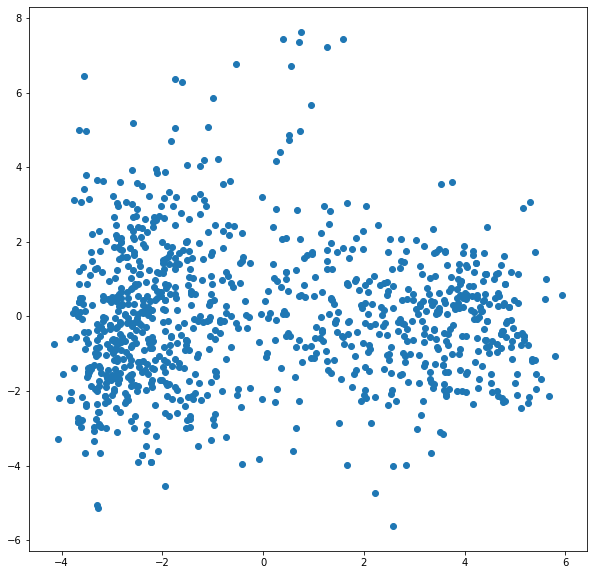

In [15]:
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(projection='3d')
#ax.scatter(X_3d.T[0], X_3d.T[1], X_3d.T[2], marker='o')
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], marker='o')
plt.show()

### Classes in Test Data:

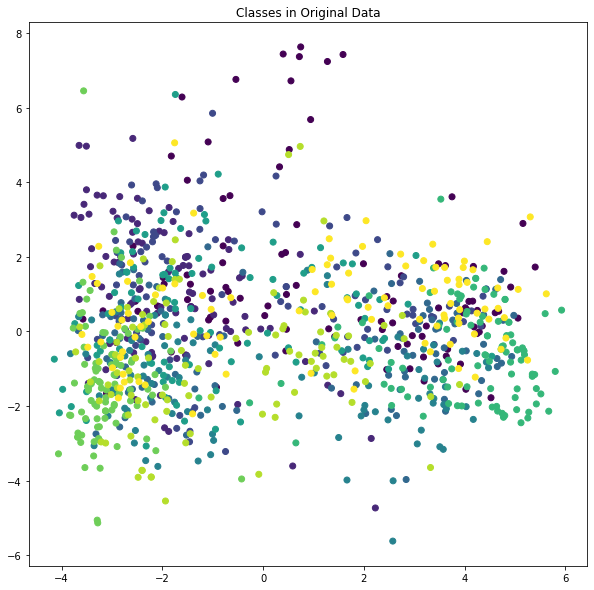

In [16]:
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(projection='3d')
#ax.scatter(X_3d.T[0], X_3d.T[1], X_3d.T[2], c=np.unique(y, return_inverse=True)[1], marker='o')
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=np.unique(y, return_inverse=True)[1], marker='o')
plt.title('Classes in Original Data')
plt.show()

### Overlapping Classes Obtained with Agglomerative Model:

In [17]:
yhat = _30_base_model.labels_

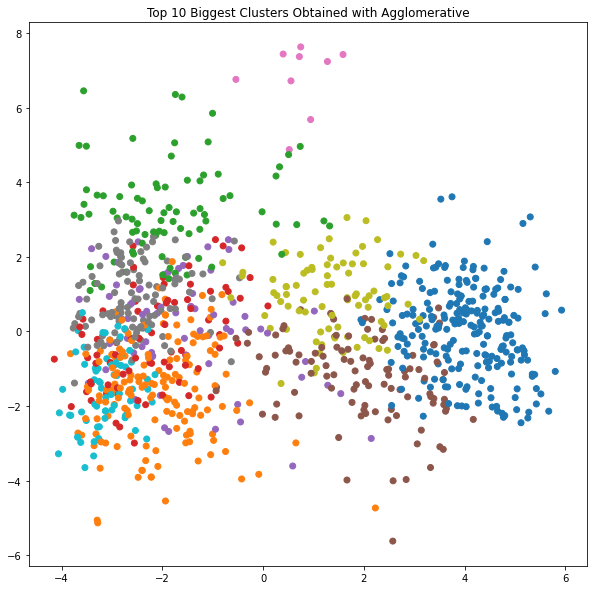

In [18]:
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(projection='3d')
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
#ax.scatter(X_3d.T[0], X_3d.T[1], X_3d.T[2], c=yhat, cmap=color, marker='o')
plt.scatter(X_2d.T[0], X_2d.T[1], c=yhat, cmap=color, marker='o')
plt.title('Top 10 Biggest Clusters Obtained with Agglomerative')
plt.show()

In [19]:
sklearn.metrics.silhouette_score(X, yhat, random_state=123)

0.10487642733458477

Silhouette score is relatively close to 0, indicating we have indeed found overlapping clusters.

Silhouette score reference: <br>
*Rousseeuw, P. J. (1987). Silhouettes: a graphical aid to the interpretation and validation of cluster analysis. Journal of computational and applied mathematics, 20, 53-65.*

---

# 3. Parameters Tuning

## 3.1 With Extreme Value Theory:

Fit null model:

In [20]:
_30_original = sklearn.cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0, compute_distances=True).fit(X)

Obtain all possible distances:

In [21]:
_30_distances = _30_original.distances_

In [22]:
np.min(_30_distances)

0.0

In [23]:
np.max(_30_distances)

114.0140215401505

Use **Extreme Value Theory** to find optimal distance threshold:

Ref:<br>
*Li, C., Günther, M., Dhamija, A. R., Cruz, S., Jafarzadeh, M., Ahmad, T., & Boult, T. E. (2022). Agglomerative Clustering with Threshold Optimization via Extreme Value Theory. Algorithms, 15(5), 170.*

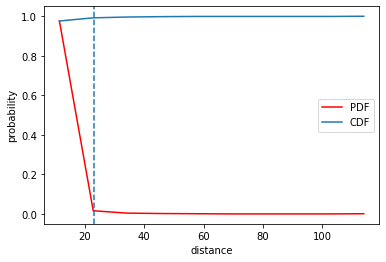

In [24]:
count, bins_count = np.histogram(_30_distances)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.axvline(x=23, linestyle='dashed')
plt.xlabel('distance')
plt.ylabel('probability')
plt.legend()

Hence, we know the distance threshold is around 23.

In [25]:
_30_model_opt = sklearn.cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold = 23, compute_distances=True).fit(X)

In [26]:
yhat_opt = _30_model_opt.labels_

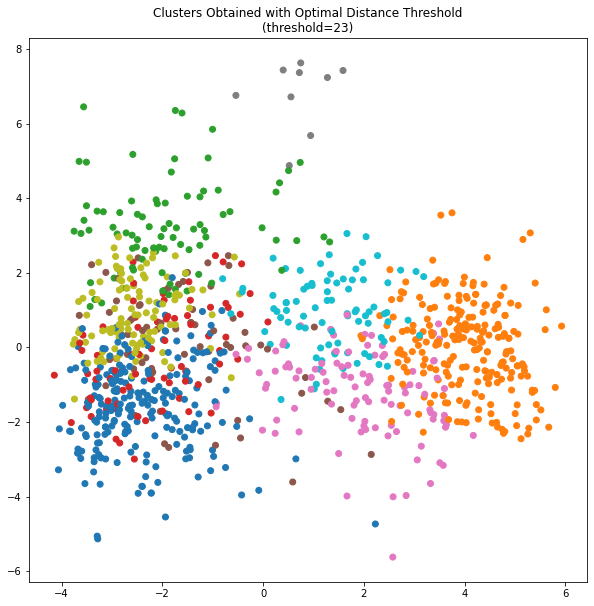

In [27]:
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(projection='3d')
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
#ax.scatter(X_3d.T[0], X_3d.T[1], X_3d.T[2], c=yhat_opt, cmap=color, marker='o')
plt.scatter(X_2d.T[0], X_2d.T[1], c=yhat_opt, cmap=color, marker='o')
plt.title('Clusters Obtained with Optimal Distance Threshold\n(threshold=23)')
plt.show()

In [28]:
sklearn.metrics.silhouette_score(X, yhat_opt, random_state=123)

0.1155575124409874

Silhouette score is relatively close to 0, indicating we have indeed found overlapping clusters.

## 3.2 With Silhouette Score Search:

## 3.2.1 Ward Linkage:

In [29]:
n_clusters = []
sil_scores = []
for nc in range(2,21):
    m = sklearn.cluster.AgglomerativeClustering(n_clusters=nc, linkage='ward').fit(X)
    s = sklearn.metrics.silhouette_score(X, m.labels_, random_state=123)
    n_clusters.append(nc)
    sil_scores.append(s)

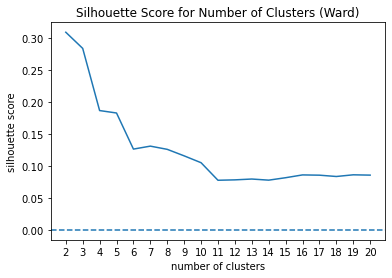

In [30]:
plt.plot(n_clusters, sil_scores)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.xticks(n_clusters)
plt.axhline(y=0, linestyle='dashed')
plt.title('Silhouette Score for Number of Clusters (Ward)')
plt.show()

In [31]:
_30_original_comp = sklearn.cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0, compute_distances=True).fit(X)
np.max(_30_original_comp.distances_)

114.0140215401505

In [32]:
distance_th = []
n_clusters_from_th = []
sil_scores = []
for dt in range(1,115):
    m = sklearn.cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=dt, linkage='ward').fit(X)
    s = sklearn.metrics.silhouette_score(X, m.labels_, random_state=123)
    distance_th.append(dt)
    sil_scores.append(s)
    n_clusters_from_th.append(len(np.unique(m.labels_)))

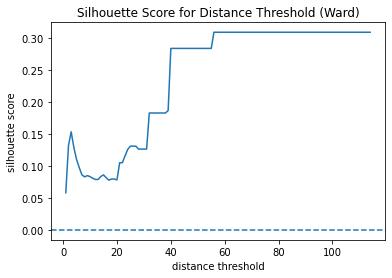

In [33]:
plt.plot(distance_th, sil_scores)
plt.xlabel('distance threshold')
plt.ylabel('silhouette score')
#plt.xticks(distance_th)
plt.axhline(y=0, linestyle='dashed')
plt.title('Silhouette Score for Distance Threshold (Ward)')
plt.show()

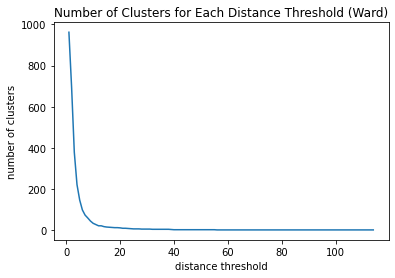

In [34]:
plt.plot(distance_th, n_clusters_from_th)
plt.xlabel('distance threshold')
plt.ylabel('number of clusters')
#plt.xticks(distance_th)
plt.title('Number of Clusters for Each Distance Threshold (Ward)')
plt.show()

In [35]:
ward_m1 = sklearn.cluster.AgglomerativeClustering(n_clusters=11, linkage='ward', compute_distances =True).fit(X)
ward_s1 = sklearn.metrics.silhouette_score(X, ward_m1.labels_, random_state=123)
ward_m2 = sklearn.cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=20, linkage='ward', compute_distances =True).fit(X)
ward_s2 = sklearn.metrics.silhouette_score(X, ward_m2.labels_, random_state=123)

In [36]:
print(f'Silhouette score for complete linkage model with n_clust = 5: {ward_s1}')
print(f'Silhouette score for complete linkage model with threshold = 6: {ward_s2}')

Silhouette score for complete linkage model with n_clust = 5: 0.07748764917008956
Silhouette score for complete linkage model with threshold = 6: 0.07810824318482225


In [37]:
print(f'Number of clusters in complete linkage model with n_clust = 5: {len(np.unique(ward_m1.labels_))}')
print(f'Number of clusters in complete linkage model with threshold = 6: {len(np.unique(ward_m2.labels_))}')

Number of clusters in complete linkage model with n_clust = 5: 11
Number of clusters in complete linkage model with threshold = 6: 12


That is, for ward linkage, model with optimal `n_clusters=11` has a lower silhouette score, indicating better overlap performance than using `distance_threshold=20`. Hence we will choose `n_clusters=11` as the ward optimal model for now.

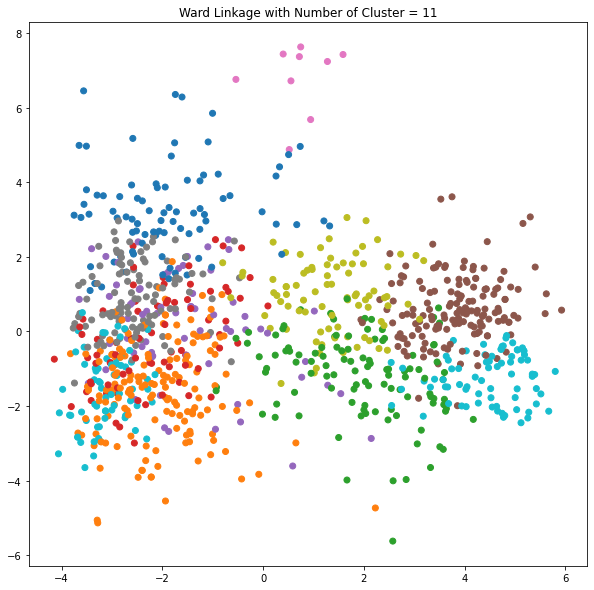

In [38]:
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(projection='3d')
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
#ax.scatter(X_3d.T[0], X_3d.T[1], X_3d.T[2], c=yhat_opt, cmap=color, marker='o')
plt.scatter(X_2d.T[0], X_2d.T[1], c=ward_m1.labels_,  cmap=color, marker='o')
plt.title('Ward Linkage with Number of Cluster = 11')
plt.show()

## 3.2.2 Complete Linkage

In [39]:
n_clusters = []
sil_scores = []
for nc in range(2,21):
    m = sklearn.cluster.AgglomerativeClustering(n_clusters=nc, linkage='complete').fit(X)
    s = sklearn.metrics.silhouette_score(X, m.labels_, random_state=123)
    n_clusters.append(nc)
    sil_scores.append(s)

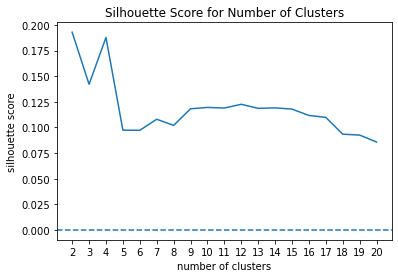

In [40]:
plt.plot(n_clusters, sil_scores)
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.xticks(n_clusters)
plt.axhline(y=0, linestyle='dashed')
plt.title('Silhouette Score for Number of Clusters')
plt.show()

In [41]:
_30_original_comp = sklearn.cluster.AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=0, compute_distances=True).fit(X)
np.max(_30_original_comp.distances_)

16.291768238631963

In [42]:
distance_th = []
n_clusters_from_th = []
sil_scores = []
for dt in range(1,17):
    m = sklearn.cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=dt, linkage='complete').fit(X)
    s = sklearn.metrics.silhouette_score(X, m.labels_, random_state=123)
    distance_th.append(dt)
    sil_scores.append(s)
    n_clusters_from_th.append(len(np.unique(m.labels_)))

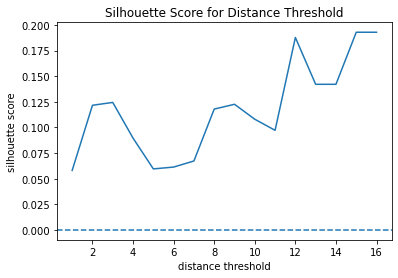

In [43]:
plt.plot(distance_th, sil_scores)
plt.xlabel('distance threshold')
plt.ylabel('silhouette score')
#plt.xticks(distance_th)
plt.axhline(y=0, linestyle='dashed')
plt.title('Silhouette Score for Distance Threshold')
plt.show()

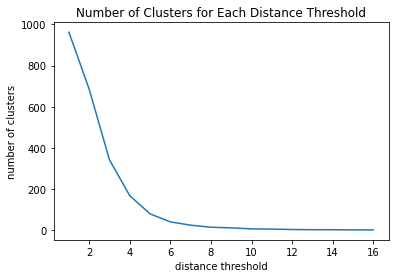

In [44]:
plt.plot(distance_th, n_clusters_from_th)
plt.xlabel('distance threshold')
plt.ylabel('number of clusters')
#plt.xticks(distance_th)
plt.title('Number of Clusters for Each Distance Threshold')
plt.show()

In [45]:
comp_m1 = sklearn.cluster.AgglomerativeClustering(n_clusters=5, linkage='complete', compute_distances =True).fit(X)
comp_s1 = sklearn.metrics.silhouette_score(X, comp_m1.labels_, random_state=123)
comp_m2 = sklearn.cluster.AgglomerativeClustering(n_clusters=None, distance_threshold=6, linkage='complete', compute_distances =True).fit(X)
comp_s2 = sklearn.metrics.silhouette_score(X, comp_m2.labels_, random_state=123)

In [46]:
print(f'Silhouette score for complete linkage model with n_clust = 5: {comp_s1}')
print(f'Silhouette score for complete linkage model with threshold = 6: {comp_s2}')

Silhouette score for complete linkage model with n_clust = 5: 0.09733084007665249
Silhouette score for complete linkage model with threshold = 6: 0.06132323043218533


In [47]:
print(f'Number of clusters in complete linkage model with n_clust = 5: {len(np.unique(comp_m1.labels_))}')
print(f'Number of clusters in complete linkage model with threshold = 6: {len(np.unique(comp_m2.labels_))}')

Number of clusters in complete linkage model with n_clust = 5: 5
Number of clusters in complete linkage model with threshold = 6: 41


Both model with complete linkage give higher silhouette score compared to using ward linkage, at the same time having 41 clusters does not seem to be realistic on our data since there are only 10 original labelled classes.<br>
**Hence, we discard the complete linkage model**.

That is, our final chosen agglomerative model will be model with ward linkage and number of clusters set to 11.

---

# 4. Best Model (so far)

From previously discussed, our final agglomerative model will be using ward linkage and with number of clusters set to 11.

In [48]:
agg_best = ward_m1

In [49]:
def get_class_distribution(model, y):
    class_mtx = {}
    for i in range(len(y)):
        if model.labels_[i] not in class_mtx:
            class_mtx[model.labels_[i]] = []
            class_mtx[model.labels_[i]].append(y[i])
        else:
            class_mtx[model.labels_[i]].append(y[i])
    for k in class_mtx.copy().keys():
        freq_mtx = {}
        for i in class_mtx[k]:
            if i in freq_mtx:
                freq_mtx[i] += 1
            else:
                freq_mtx[i] = 1
        freq_mtx = dict(sorted(freq_mtx.items(), key=lambda item: item[1], reverse=True))
        class_mtx[k] = freq_mtx
    for i in class_mtx.keys():
        s = sum(class_mtx[i].values())
        for cl in class_mtx[i].keys():
            class_mtx[i][cl] = str(round((class_mtx[i][cl] / s) * 100, 1)) + '%'
    return class_mtx

## 4.1 Evaluate Best Model

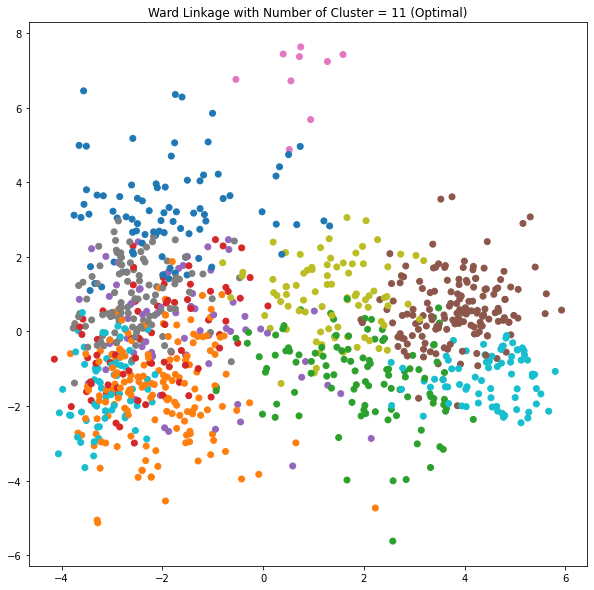

In [50]:
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(projection='3d')
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
#ax.scatter(X_3d.T[0], X_3d.T[1], X_3d.T[2], c=yhat_opt, cmap=color, marker='o')
plt.scatter(X_2d.T[0], X_2d.T[1], c=agg_best.labels_,  cmap=color, marker='o')
plt.title('Ward Linkage with Number of Cluster = 11 (Optimal)')
plt.show()

We then display the denrogram:

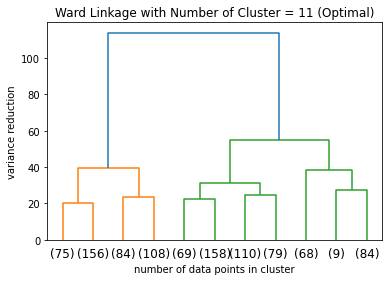

In [51]:
plt.title("Ward Linkage with Number of Cluster = 11 (Optimal)")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_best, truncate_mode="lastp", p=11)
plt.xlabel("number of data points in cluster")
plt.ylabel("variance reduction")
plt.show()

In [52]:
uq,counts = np.unique(agg_best.labels_, return_counts= True)
class_freq = {uq[i]:counts[i] for i in range(len(uq))}
class_freq = dict(sorted(class_freq.items(), key=lambda item: item[1]))

In [53]:
for k,v in class_freq.items():
    print(f'Cluster ID: {k}\tNumber of Data in Cluster: {v}')

Cluster ID: 6	Number of Data in Cluster: 9
Cluster ID: 4	Number of Data in Cluster: 68
Cluster ID: 9	Number of Data in Cluster: 69
Cluster ID: 10	Number of Data in Cluster: 75
Cluster ID: 3	Number of Data in Cluster: 79
Cluster ID: 0	Number of Data in Cluster: 84
Cluster ID: 8	Number of Data in Cluster: 84
Cluster ID: 2	Number of Data in Cluster: 108
Cluster ID: 7	Number of Data in Cluster: 110
Cluster ID: 5	Number of Data in Cluster: 156
Cluster ID: 1	Number of Data in Cluster: 158


In [54]:
for k,v in get_class_distribution(agg_best, y).items():
    print(f'Cluster ID {k}:', end='\t')
    print(list(v.keys())[0], v[list(v.keys())[0]])

Cluster ID 2:	hiphop 27.8%
Cluster ID 8:	country 22.6%
Cluster ID 3:	blues 31.6%
Cluster ID 0:	classical 36.9%
Cluster ID 6:	blues 100.0%
Cluster ID 5:	metal 23.7%
Cluster ID 1:	hiphop 27.2%
Cluster ID 10:	metal 68.0%
Cluster ID 4:	classical 85.3%
Cluster ID 7:	country 20.0%
Cluster ID 9:	pop 75.4%


In [66]:
for k,v in get_class_distribution(agg_best, y).items():
    print(f'Cluster ID {k}:')
    print(v)
    print()

Cluster ID 2:
{'hiphop': '27.8%', 'reggae': '27.8%', 'disco': '13.0%', 'jazz': '12.0%', 'blues': '6.5%', 'country': '5.6%', 'rock': '4.6%', 'metal': '2.8%'}

Cluster ID 8:
{'country': '22.6%', 'rock': '22.6%', 'jazz': '16.7%', 'blues': '11.9%', 'metal': '7.1%', 'reggae': '7.1%', 'hiphop': '4.8%', 'classical': '3.6%', 'disco': '3.6%'}

Cluster ID 3:
{'blues': '31.6%', 'jazz': '21.5%', 'reggae': '21.5%', 'country': '8.9%', 'pop': '6.3%', 'hiphop': '3.8%', 'disco': '2.5%', 'rock': '2.5%', 'classical': '1.3%'}

Cluster ID 0:
{'classical': '36.9%', 'country': '21.4%', 'jazz': '21.4%', 'blues': '11.9%', 'reggae': '3.6%', 'pop': '2.4%', 'rock': '2.4%'}

Cluster ID 6:
{'blues': '100.0%'}

Cluster ID 5:
{'metal': '23.7%', 'blues': '21.8%', 'rock': '21.8%', 'disco': '18.6%', 'country': '8.3%', 'hiphop': '3.8%', 'reggae': '1.3%', 'jazz': '0.6%'}

Cluster ID 1:
{'hiphop': '27.2%', 'reggae': '17.7%', 'pop': '15.8%', 'rock': '10.8%', 'disco': '10.1%', 'country': '7.6%', 'jazz': '7.0%', 'metal': '1.9

In [55]:
pd.DataFrame.from_dict(get_class_distribution(agg_best, y))

,2,8,3,0,6,5,1,10,4,7,9
hiphop,27.8%,4.8%,3.8%,NaN,NaN,3.8%,27.2%,5.3%,1.5%,6.4%,2.9%
reggae,27.8%,7.1%,21.5%,3.6%,NaN,1.3%,17.7%,1.3%,1.5%,9.1%,2.9%
disco,13.0%,3.6%,2.5%,NaN,NaN,18.6%,10.1%,10.7%,1.5%,17.3%,11.6%
jazz,12.0%,16.7%,21.5%,21.4%,NaN,0.6%,7.0%,1.3%,8.8%,14.5%,4.3%
blues,6.5%,11.9%,31.6%,11.9%,100.0%,21.8%,0.6%,5.3%,NaN,NaN,NaN
country,5.6%,22.6%,8.9%,21.4%,NaN,8.3%,7.6%,1.3%,1.5%,20.0%,1.4%
rock,4.6%,22.6%,2.5%,2.4%,NaN,21.8%,10.8%,6.7%,NaN,13.6%,1.4%
metal,2.8%,7.1%,NaN,NaN,NaN,23.7%,1.9%,68.0%,NaN,NaN,NaN
classical,NaN,3.6%,1.3%,36.9%,NaN,NaN,1.3%,NaN,85.3%,4.5%,NaN
pop,NaN,NaN,6.3%,2.4%,NaN,NaN,15.8%,NaN,NaN,14.5%,75.4%


## 4.2 Explore Parent Clusters & Additional EDA

We now get the distribution of parent clusters, i.e. prune the hierarchy tree to only 5 clusters:

In [56]:
agg_parents = sklearn.cluster.AgglomerativeClustering(n_clusters=5, linkage='ward', compute_distances=True).fit(X)

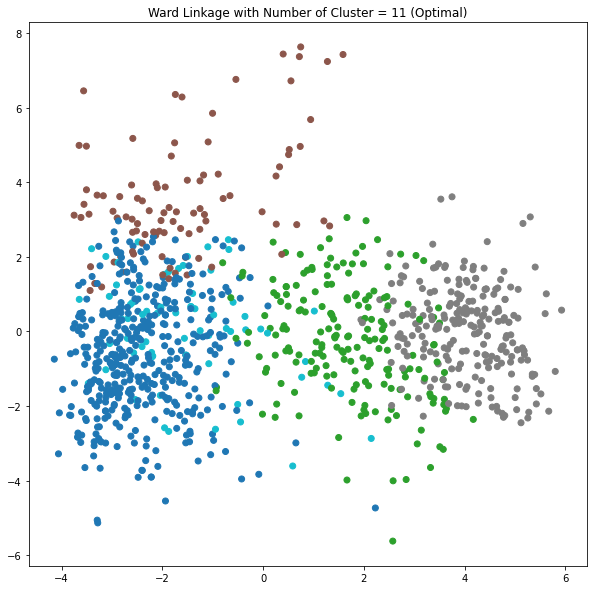

In [57]:
#fig = plt.figure(figsize=(10, 10))
#ax = fig.add_subplot(projection='3d')
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
#ax.scatter(X_3d.T[0], X_3d.T[1], X_3d.T[2], c=yhat_opt, cmap=color, marker='o')
plt.scatter(X_2d.T[0], X_2d.T[1], c=agg_parents.labels_,  cmap=color, marker='o')
plt.title('Ward Linkage with Number of Cluster = 11 (Optimal)')
plt.show()

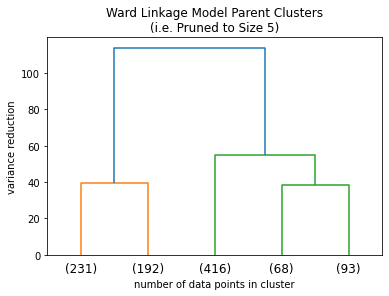

In [58]:
plt.title("Ward Linkage Model Parent Clusters\n(i.e. Pruned to Size 5)")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_parents, truncate_mode="lastp", p=5)
plt.xlabel("number of data points in cluster")
plt.ylabel("variance reduction")
plt.show()

In [59]:
uq,counts = np.unique(agg_parents.labels_, return_counts= True)
class_freq = {uq[i]:counts[i] for i in range(len(uq))}
class_freq = dict(sorted(class_freq.items(), key=lambda item: item[1]))

In [60]:
for k,v in class_freq.items():
    print(f'Cluster ID: {k}\tNumber of Data in Cluster: {v}')

Cluster ID: 4	Number of Data in Cluster: 68
Cluster ID: 2	Number of Data in Cluster: 93
Cluster ID: 1	Number of Data in Cluster: 192
Cluster ID: 3	Number of Data in Cluster: 231
Cluster ID: 0	Number of Data in Cluster: 416


In [61]:
for k,v in get_class_distribution(agg_parents, y).items():
    print(f'Cluster ID {k}:')
    print(v)
    print()

Cluster ID 1:
{'reggae': '18.8%', 'hiphop': '17.7%', 'jazz': '14.1%', 'country': '13.0%', 'rock': '12.5%', 'blues': '8.9%', 'disco': '8.9%', 'metal': '4.7%', 'classical': '1.6%'}

Cluster ID 0:
{'pop': '23.6%', 'reggae': '13.7%', 'hiphop': '13.2%', 'jazz': '11.3%', 'disco': '10.8%', 'country': '10.1%', 'rock': '8.4%', 'blues': '6.2%', 'classical': '1.9%', 'metal': '0.7%'}

Cluster ID 2:
{'classical': '33.3%', 'blues': '20.4%', 'country': '19.4%', 'jazz': '19.4%', 'reggae': '3.2%', 'pop': '2.2%', 'rock': '2.2%'}

Cluster ID 3:
{'metal': '38.1%', 'rock': '16.9%', 'blues': '16.5%', 'disco': '16.0%', 'country': '6.1%', 'hiphop': '4.3%', 'reggae': '1.3%', 'jazz': '0.9%'}

Cluster ID 4:
{'classical': '85.3%', 'jazz': '8.8%', 'country': '1.5%', 'disco': '1.5%', 'hiphop': '1.5%', 'reggae': '1.5%'}



In [62]:
for k,v in get_class_distribution(agg_parents, y).items():
    print(f'Cluster ID {k}:', end='  ')
    print(list(v.keys())[0], v[list(v.keys())[0]], end='\t')
    print(list(v.keys())[1], v[list(v.keys())[1]])

Cluster ID 1:  reggae 18.8%	hiphop 17.7%
Cluster ID 0:  pop 23.6%	reggae 13.7%
Cluster ID 2:  classical 33.3%	blues 20.4%
Cluster ID 3:  metal 38.1%	rock 16.9%
Cluster ID 4:  classical 85.3%	jazz 8.8%


In [63]:
pd.DataFrame.from_dict(get_class_distribution(agg_parents, y))

,1,0,2,3,4
reggae,18.8%,13.7%,3.2%,1.3%,1.5%
hiphop,17.7%,13.2%,NaN,4.3%,1.5%
jazz,14.1%,11.3%,19.4%,0.9%,8.8%
country,13.0%,10.1%,19.4%,6.1%,1.5%
rock,12.5%,8.4%,2.2%,16.9%,NaN
blues,8.9%,6.2%,20.4%,16.5%,NaN
disco,8.9%,10.8%,NaN,16.0%,1.5%
metal,4.7%,0.7%,NaN,38.1%,NaN
classical,1.6%,1.9%,33.3%,NaN,85.3%
pop,NaN,23.6%,2.2%,NaN,NaN


In [64]:
best_sil = sklearn.metrics.silhouette_score(X, agg_best.labels_, random_state=123)
best_sil

0.07748764917008956

In [65]:
parent_sil = sklearn.metrics.silhouette_score(X, agg_parents.labels_, random_state=123)
parent_sil

0.1824452368239408